In [1]:
import numpy as np
import json

from spektral.data import DisjointLoader

from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../src/')
from datasets import L3VPN_dataset, CEPE_dataset, PEs_dataset
import CEPE_model, PEs_model
import plot_reports

In [2]:
################################################################################
# Load models
################################################################################


dir = '../models/'
# Load PEs model
with open(dir+'pes_model/parameters.json') as json_file:
        pes_model_parameters = json.load(json_file)

pes_model = PEs_model.create_model(n_node_features=pes_model_parameters['n_node_features'],
                                   n_edge_features=pes_model_parameters['n_edge_features'],
                                   n_labels=pes_model_parameters['n_labels'],
                                   pes_channels=pes_model_parameters['pes_channels'],
                                   learning_rate=pes_model_parameters['learning_rate']  
                                )
pes_load_status = pes_model.load_weights(dir+'pes_model/ckpt')


# Load CE-PE routing model
with open(dir+'cepe_model/parameters.json') as json_file:
        cepe_model_parameters = json.load(json_file)

cepe_model = CEPE_model.create_model(n_node_features=cepe_model_parameters['n_node_features'],
                                    n_labels=cepe_model_parameters['n_labels'],
                                    gc_layer=cepe_model_parameters['gc_layer'], 
                                    cepe_channels=cepe_model_parameters['cepe_channels'],
                                    learning_rate=cepe_model_parameters['learning_rate']
                                    )
cepe_load_status = cepe_model.load_weights(dir+'cepe_model/ckpt')

## - F1-Score according to the number of CEs per VPN

In [3]:
%%time

# parameters
n_ce = [3, 5, 10, 20, 30, 40]
n_pe = 20
n_customers = 300
VPN_Type = 2

# Generate test DATA
l3vpn_datasets = [ L3VPN_dataset(n_samples=n_customers, n_pe=n_pe, n_ce_min=n, n_ce_max=n, VPN_Type=VPN_Type) for n in n_ce ]
pes_datasets = [ PEs_dataset(l3vpn_dataset) for l3vpn_dataset in l3vpn_datasets ]
cepe_datasets = [ CEPE_dataset(l3vpn_dataset, n_faults=29) for l3vpn_dataset in l3vpn_datasets ]

CPU times: user 4min 4s, sys: 2.16 s, total: 4min 6s
Wall time: 4min 4s


In [4]:
# calculate results for PE-PE model
pes_precision, pes_recall, pes_f1_score, pes_accuracy, pes_loss = [], [], [], [], []

for pes_dataset in pes_datasets:
    # todo print evaluation for iter i

    # create a Disjoint loaders for test datasets
    pes_loader = DisjointLoader(pes_dataset, node_level=True, batch_size=len(pes_dataset), shuffle=True)

    batch = pes_loader.__next__()
    inputs, target = batch

    # calculate loss and accuracy values
    loss, acc = pes_model.evaluate(pes_loader.load(),steps=pes_loader.steps_per_epoch)
    
    # calculate the classification report
    pes_predicted = pes_model(inputs)
    pes_report = classification_report(target, np.rint(pes_predicted))
    precision, recall, f1_score = plot_reports.get_precision_recall_f1_score(pes_report)

    pes_precision.append(precision)
    pes_recall.append(recall)
    pes_f1_score.append(f1_score)
    pes_accuracy.append(acc)
    pes_loss.append(loss)

1/1 [==============================] - 0s 251ms/step - loss: 0.7904 - acc: 0.8795


In [5]:
# calculate results for CE-PE model
cepe_precision, cepe_recall, cepe_f1_score, cepe_accuracy, cepe_loss = [], [], [], [], []

for cepe_dataset in cepe_datasets:
    # todo print evaluation for iter i

    # create a Disjoint loader for test dataset
    cepe_loader = DisjointLoader(cepe_dataset, batch_size=len(cepe_dataset), shuffle=True)

    batch = cepe_loader.__next__()
    inputs, target = batch

    # calculate loss and accuracy values
    loss, acc = cepe_model.evaluate(cepe_loader.load(),steps=cepe_loader.steps_per_epoch)

    # calculate the classification report
    cepe_predicted = cepe_model(inputs)
    cepe_report = classification_report(target, np.rint(cepe_predicted))
    precision, recall, f1_score = plot_reports.get_precision_recall_f1_score(cepe_report)

    cepe_precision.append(precision)
    cepe_recall.append(recall)
    cepe_f1_score.append(f1_score)
    cepe_accuracy.append(acc)
    cepe_loss.append(loss)

1/1 [==============================] - 31s 31s/step - loss: 0.2486 - acc: 0.9816


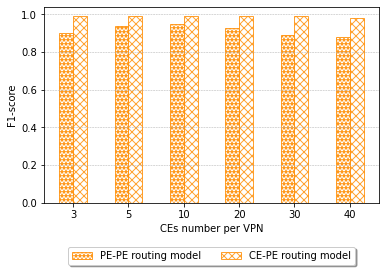

In [6]:
# Plot graph
pdf = plot_reports.plot_f1_score(pes_f1_score, cepe_f1_score, classes=n_ce, xlabel='CEs number per VPN' , output_file= '../results/f1_score_ces.pdf')

## - Detailed performance per VPN type for PEs routing model

In [7]:
%%time

# parameters
n_ce_min = 10
n_ce_max = 30
n_pe = 20
n_customers = 300
VPN_Type = [0, 1, 2]

# Generate test DATA
l3vpn_datasets = [ L3VPN_dataset(n_samples=n_customers, n_pe=n_pe, n_ce_min=n_ce_min, n_ce_max=n_ce_max, VPN_Type=n) for n in VPN_Type ]
pes_datasets = [ PEs_dataset(l3vpn_dataset) for l3vpn_dataset in l3vpn_datasets ]

CPU times: user 2min 5s, sys: 1.25 s, total: 2min 6s
Wall time: 2min 5s


In [8]:
# calculate results for PE-PE model
pes_precision, pes_recall, pes_f1_score, pes_accuracy, pes_loss = [], [], [], [], []

for pes_dataset in pes_datasets:
    # todo print evaluation for iter i

    # create a Disjoint loaders for test datasets
    pes_loader = DisjointLoader(pes_dataset, node_level=True, batch_size=len(pes_dataset), shuffle=True)

    batch = pes_loader.__next__()
    inputs, target = batch

    # calculate loss and accuracy values
    loss, acc = pes_model.evaluate(pes_loader.load(),steps=pes_loader.steps_per_epoch)
    
    # calculate the classification report
    pes_predicted = pes_model(inputs)
    pes_report = classification_report(target, np.rint(pes_predicted))
    precision, recall, f1_score = plot_reports.get_precision_recall_f1_score(pes_report)

    pes_precision.append(precision)
    pes_recall.append(recall)
    pes_f1_score.append(f1_score)
    pes_accuracy.append(acc)
    pes_loss.append(loss)

1/1 [==============================] - 0s 260ms/step - loss: 0.4919 - acc: 0.9320


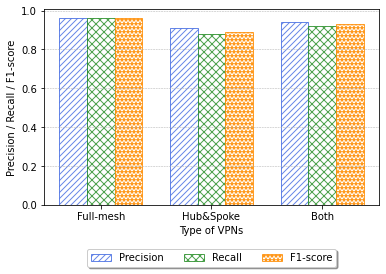

In [9]:
# Plot graph
pdf = plot_reports.plot_general_report(pes_precision, pes_recall, pes_f1_score, classes=['Full-mesh', 'Hub&Spoke', 'Both'], xlabel='Type of VPNs', output_file= '../results/vpn_types.pdf')

## - Detailed performance for both models

In [10]:
%%time

# parameters
n_ce_min = 10
n_ce_max = 30
n_pe = 20
n_customers = 300
VPN_Type = 2

# Generate test DATA
l3vpn_dataset = L3VPN_dataset(n_samples=n_customers, n_pe=n_pe, n_ce_min=n_ce_min, n_ce_max=n_ce_max, VPN_Type=VPN_Type)
pes_dataset = PEs_dataset(l3vpn_dataset)
cepe_dataset = CEPE_dataset(l3vpn_dataset, n_faults=29)

CPU times: user 48.9 s, sys: 504 ms, total: 49.4 s
Wall time: 48.8 s


In [11]:
# create a Disjoint loaders for test datasets
pes_loader = DisjointLoader(pes_dataset, node_level=True, batch_size=len(pes_dataset), shuffle=True)

batch = pes_loader.__next__()
inputs, target = batch

# calculate the classification report
pes_predicted = pes_model(inputs)
pes_report = classification_report(target, np.rint(pes_predicted))

In [12]:
# create a Disjoint loader for test dataset
cepe_loader = DisjointLoader(cepe_dataset, batch_size=len(cepe_dataset), shuffle=True)

batch = cepe_loader.__next__()
inputs, target = batch


# calculate the classification report
cepe_predicted = cepe_model(inputs)
cepe_report = classification_report(target, np.rint(cepe_predicted))

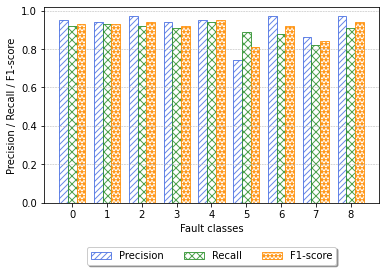

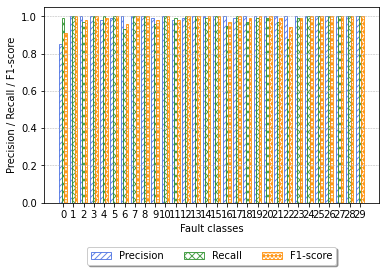

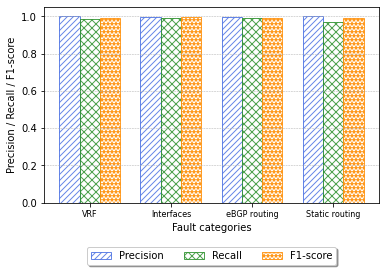

In [13]:
from importlib import reload
reload(plot_reports)

pdf = plot_reports.plot_classification_report(pes_report, '../results/PEs_detailed_report.pdf', title='PEs Classification report')
pdf = plot_reports.plot_classification_report(cepe_report, '../results/CEPE_detailed_report.pdf', title='CE-PE Classification report')
pdf = plot_reports.plot_cepe_category_classification_report(cepe_report, '../results/CEPE_cat_report.pdf', title='CE-PE classification report per category')